## Load libraries and data

In [166]:
# load relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [167]:
# load the data by reading the raw csv file
# use parse_dates argument to read the date column in datetime format
btc = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", parse_dates=['Timestamp'], usecols=['Timestamp', 'Weighted_Price'])

In [168]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


## Explore the data

In [169]:
btc.shape

(4857377, 2)

In [170]:
# check data types
btc.dtypes

Timestamp          object
Weighted_Price    float64
dtype: object

In [171]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


In [172]:
btc.tail()

,Timestamp,Weighted_Price
4857372,1617148560,58692.753339
4857373,1617148620,58693.226508
4857374,1617148680,58696.198496
4857375,1617148740,58761.866202
4857376,1617148800,58764.349363


### Check and drop null values

In [173]:
# check how many rows have non-null values
btc.notnull().sum()

Timestamp         4857377
Weighted_Price    3613769
dtype: int64

As there are over 1 million rows having null value, I'm going to drop them.

In [174]:
# drop null rows
btc = btc.dropna()

In [175]:
# check if null values are all removed
btc.isnull().values.any()

False

In [176]:
btc.shape

(3613769, 2)

In [177]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
478,1325346600,4.390000
547,1325350740,4.526411
548,1325350800,4.580000
1224,1325391360,4.580000


### Reset index

In [178]:
btc.reset_index(drop=True, inplace=True)
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
1,1325346600,4.390000
2,1325350740,4.526411
3,1325350800,4.580000
4,1325391360,4.580000


## Cleaning, transforming and visualizing

### The timestamps are in Unix time so I'm going to transform it to datetime

In [179]:
btc['Timestamp'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc.dtypes

Timestamp         datetime64[ns]
Weighted_Price           float64
dtype: object

In [180]:
btc.head(5)

,Timestamp,Weighted_Price
0,2011-12-31 07:52:00,4.390000
1,2011-12-31 15:50:00,4.390000
2,2011-12-31 16:59:00,4.526411
3,2011-12-31 17:00:00,4.580000
4,2012-01-01 04:16:00,4.580000


In [181]:
btc.tail(5)

,Timestamp,Weighted_Price
3613764,2021-03-30 23:56:00,58692.753339
3613765,2021-03-30 23:57:00,58693.226508
3613766,2021-03-30 23:58:00,58696.198496
3613767,2021-03-30 23:59:00,58761.866202
3613768,2021-03-31 00:00:00,58764.349363


### Plot the data

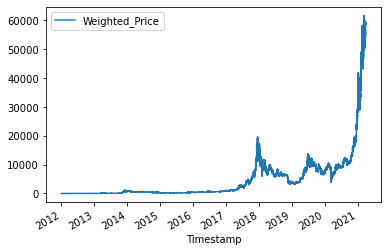

In [182]:
btc.plot(x='Timestamp', y='Weighted_Price')
plt.show()

### Downsample to daily data

In [183]:
btc.index = btc['Timestamp']
btc_daily = btc.resample('D').mean()
btc_daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


In [184]:
btc_daily = btc_daily.dropna()

In [185]:
btc_daily.isnull().values.any()

False

In [186]:
type(btc_daily)

pandas.core.frame.DataFrame

In [187]:
btc_daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


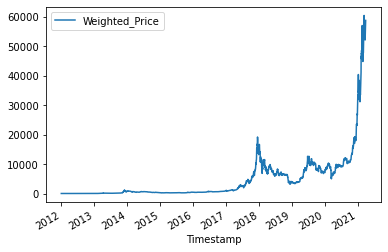

In [188]:
btc_daily.plot()

### Check for stationarity

In [189]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

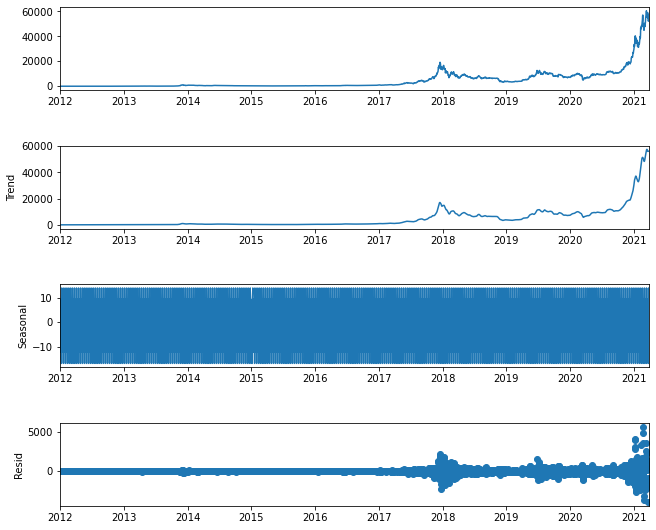

In [190]:
# Seasonal Decomposition
# observed = trend + seasonal + resid
# period(=freq) : seosonal을 볼때 주기

decomposition = sm.tsa.seasonal_decompose(btc_daily, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Does data have:  
- Trend? Increasing  
- Seasonality? No  
- Residual? Increasing

Run the augment Dicky-Fuller test as another way to check for stationarity.

In [254]:
from statsmodels.tsa.stattools import adfuller

In [271]:
# Run the ADF test and print the test statistic and the p-value
result = adfuller(btc_daily['Weighted_Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: 6.185633110386281
p-value: 1.0
critical values: {'1%': -3.4323058648629248, '5%': -2.862404186780598, '10%': -2.5672300237626606}


Since the ADF statistics is higher than the T-values, 6.18 > -3.43, -2.86, -2.56, null hypothesis cannot be rejected.  
Also, p-value of 1.0 > 0.05 (95% confidence interval), null hypothesis cannot be rejected.  
Hence, the data is non-stationary.

### Split train-test data - remove the last one month data (use this for test) and train

In [191]:
btc_daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


In [192]:
btc_daily.tail()

,Weighted_Price
Timestamp,
2021-03-27,55193.357260
2021-03-28,55832.958824
2021-03-29,56913.993819
2021-03-30,58346.912268
2021-03-31,58764.349363


In [195]:
# train_test_split
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(btc_daily, test_size=(btc_daily.index > '2021-02-28').sum(), shuffle=False, random_state=42)

In [195]:
# train_test_split
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(btc_daily, test_size=(btc_daily.index > '2019-12-31').sum(), shuffle=False, random_state=42)

In [195]:
# train_test_split
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(btc_daily, test_size=(btc_daily.index > '2020-03-31').sum(), shuffle=False, random_state=42)

In [223]:
# train_test_split
from sklearn.model_selection import train_test_split
train, test = train_test_split(btc_daily, test_size=0.2, shuffle=False, random_state=42)

This will put the last 1 year data into test.

In [224]:
test.head()

,Weighted_Price
Timestamp,
2019-05-26,8128.546958
2019-05-27,8784.562189
2019-05-28,8727.337766
2019-05-29,8648.244324
2019-05-30,8632.743964


### Plot the ACF and PACF on the train data

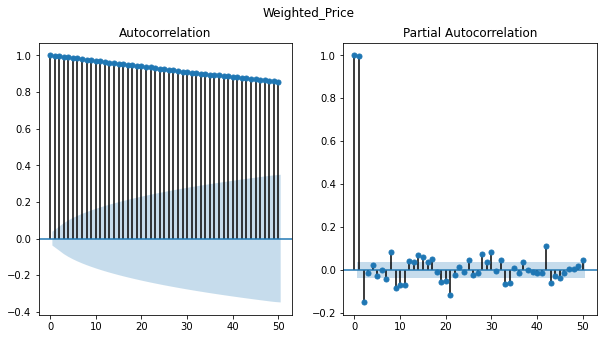

In [225]:
# Plot acf and pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Weighted_Price')
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=50, ax=ax[1]);

The ACF tails off slowly and PACF cuts off after lag 1 so I'm taking (p=0, q=1) MA(1) and the data needs to be differenced.

### Taking the difference

##### 1st order differencing

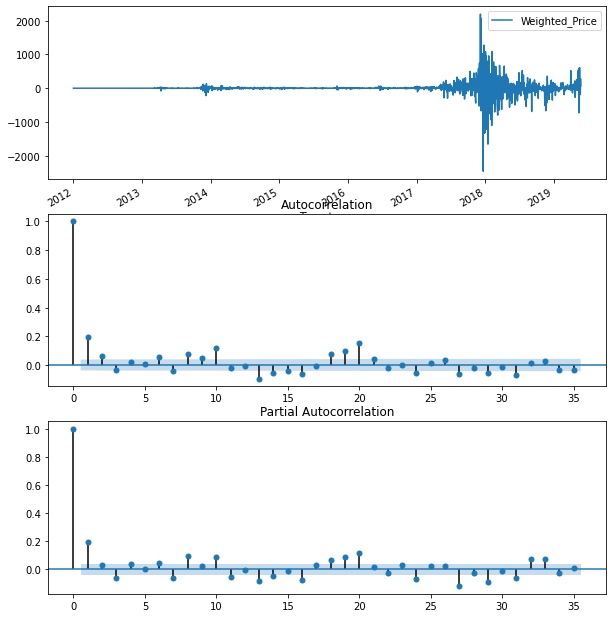

In [226]:
train_diff_1 = train.diff(periods=1).iloc[1:]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
train_diff_1.plot(ax=ax1)
plot_acf(train_diff_1, ax=ax2)
plot_pacf(train_diff_1, ax=ax3)
plt.show()

In [272]:
# Run the ADF test and print the test statistic and the p-value
result = adfuller(train_diff_1['Weighted_Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: -10.164530996453518
p-value: 7.35814516499719e-18
critical values: {'1%': -3.432801534844111, '5%': -2.862623105387403, '10%': -2.5673465738052155}


Since the ADF statistics is lower than the T-values, -10.16 < -3.43, -2.86, -2.56, null hypothesis can be rejected.  
Also, p-value of 7.35e-18 < 0.05 (95% confidence interval), null hypothesis can be rejected.  
Hence, the data is stationary.

##### 2nd order differencing

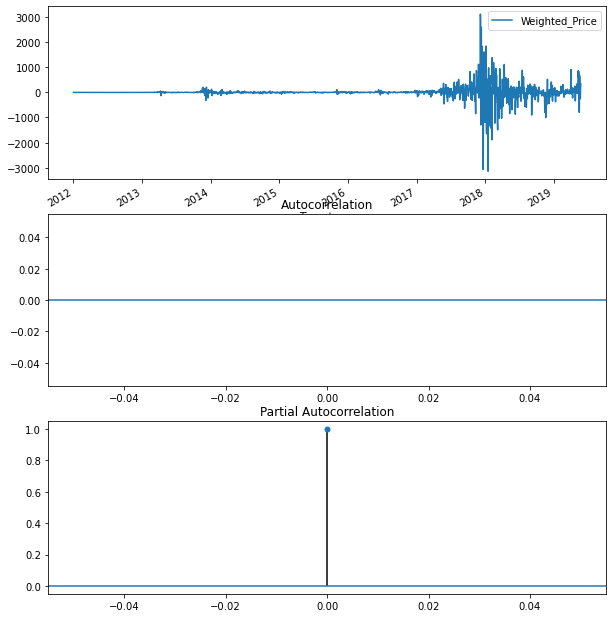

In [227]:
train_diff_2 = train.diff(periods=2).iloc[1:]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
train_diff_2.plot(ax=ax1)
plot_acf(train_diff_2, ax=ax2)
plot_pacf(train_diff_2, ax=ax3)
plt.show()

In [273]:
# Run the ADF test and print the test statistic and the p-value
result = adfuller(train_diff_2['Weighted_Price'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: -10.288902348360327
p-value: 3.613350502366686e-18
critical values: {'1%': -3.432801534844111, '5%': -2.862623105387403, '10%': -2.5673465738052155}


It seems taking the 1st order differencing would be enough.  
I'll take ARIMA(0, 1, 1) model.

## Fitting modeling - ARIMA

In [228]:
from statsmodels.tsa.arima_model import ARIMA

In [229]:
# MA(1)
model1 = ARIMA(train.values, order=(0, 1, 1))
model1_fit = model1.fit()
model1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2699
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -17669.647
Method:                       css-mle   S.D. of innovations            168.645
Date:                Tue, 12 Oct 2021   AIC                          35345.293
Time:                        22:50:19   BIC                          35362.995
Sample:                             1   HQIC                         35351.695
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9796      3.805      0.783      0.434      -4.479      10.438
ma.L1.D.y      0.1723      0.017      9.889      0.000       0.138       0.206
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -5.8031           +0.0000j            5.8031            0.5000
-----------------------------------------------------------------------------
"""

In [230]:
# MA(2)
model2 = ARIMA(train.values, order=(0, 1, 2))
model2_fit = model2.fit()
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2699
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -17660.425
Method:                       css-mle   S.D. of innovations            168.069
Date:                Tue, 12 Oct 2021   AIC                          35328.851
Time:                        22:50:21   BIC                          35352.453
Sample:                             1   HQIC                         35337.386
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9856      4.129      0.723      0.470      -5.107      11.078
ma.L1.D.y      0.1938      0.019      9.985      0.000       0.156       0.232
ma.L2.D.y      0.0827      0.019      4.287      0.000       0.045       0.120
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.1723           -3.2749j            3.4784           -0.3047
MA.2           -1.1723           +3.2749j            3.4784            0.3047
-----------------------------------------------------------------------------
"""

In [231]:
# AR(1)
model3 = ARIMA(train.values, order=(1, 1, 0))
model3_fit = model3.fit()
model3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2699
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -17664.424
Method:                       css-mle   S.D. of innovations            168.318
Date:                Tue, 12 Oct 2021   AIC                          35334.848
Time:                        22:50:23   BIC                          35352.550
Sample:                             1   HQIC                         35341.250
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9796      4.014      0.742      0.458      -4.887      10.846
ar.L1.D.y      0.1929      0.019     10.213      0.000       0.156       0.230
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.1852           +0.0000j            5.1852            0.0000
-----------------------------------------------------------------------------
"""

In [232]:
# AR(2)
model4 = ARIMA(train.values, order=(2, 1, 0))
model4_fit = model4.fit()
model4_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2699
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -17663.259
Method:                       css-mle   S.D. of innovations            168.246
Date:                Tue, 12 Oct 2021   AIC                          35334.517
Time:                        22:50:30   BIC                          35358.120
Sample:                             1   HQIC                         35343.053
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9830      4.133      0.722      0.470      -5.118      11.084
ar.L1.D.y      0.1872      0.019      9.731      0.000       0.149       0.225
ar.L2.D.y      0.0294      0.019      1.527      0.127      -0.008       0.067
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.4614           +0.0000j            3.4614            0.0000
AR.2           -9.8323           +0.0000j            9.8323            0.5000
-----------------------------------------------------------------------------
"""

In [233]:
import itertools

In [234]:
print("Examples of parameter combinations for seasonal ARIMA")
p=range(0,3)
d=range(1,2)
q=range(0,3)
pdq = list(itertools.product(p,d,q)) 

aic = []
for i in pdq:
    model=ARIMA(train.values, order=(i))
    model_fit = model.fit()
    print(f"ARIMA : {i} >> AIC : {round(model_fit.aic,2)}")
    aic.append(round(model_fit.aic,2))

Examples of parameter combinations for seasonal ARIMA
ARIMA : (0, 1, 0) >> AIC : 35435.18
ARIMA : (0, 1, 1) >> AIC : 35345.29
ARIMA : (0, 1, 2) >> AIC : 35328.85
ARIMA : (1, 1, 0) >> AIC : 35334.85
ARIMA : (1, 1, 1) >> AIC : 35335.36
ARIMA : (1, 1, 2) >> AIC : 35298.62
ARIMA : (2, 1, 0) >> AIC : 35334.52
ARIMA : (2, 1, 1) >> AIC : 35299.06
ARIMA : (2, 1, 2) >> AIC : 35328.14


In [235]:
optimal = [pdq[np.argmin(aic)], min(aic)]
optimal

[(1, 1, 2), 35298.62]

In [236]:
ARIMA_model_opt = ARIMA(train.values, order = optimal[0])
ARIMA_model_opt_fit = ARIMA_model_opt.fit()
ARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2699
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -17644.310
Method:                       css-mle   S.D. of innovations            167.066
Date:                Tue, 12 Oct 2021   AIC                          35298.619
Time:                        22:50:37   BIC                          35328.123
Sample:                             1   HQIC                         35309.289
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9793      3.920      0.760      0.447      -4.704      10.663
ar.L1.D.y     -0.9310      0.024    -39.199      0.000      -0.978      -0.884
ma.L1.D.y      1.1286      0.029     38.714      0.000       1.071       1.186
ma.L2.D.y      0.2256      0.019     12.186      0.000       0.189       0.262
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0742           +0.0000j            1.0742            0.5000
MA.1           -1.1508           +0.0000j            1.1508            0.5000
MA.2           -3.8524           +0.0000j            3.8524            0.5000
-----------------------------------------------------------------------------
"""

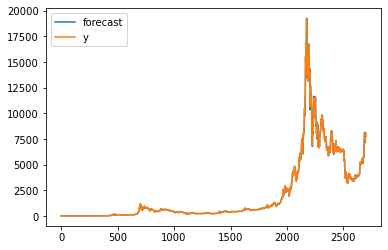

In [248]:
ARIMA_model_opt_fit.plot_predict(dynamic=False)
plt.show()

In [237]:
# use model to forecast
prediction = ARIMA_model_opt_fit.forecast(len(test))
predicted_value = prediction[0]
predicted_lb = prediction[2][:,0]
predicted_ub = prediction[2][:,1]
predict_index = list(test.index)

from sklearn.metrics import r2_score
r2 = r2_score(test, predicted_value)
r2

-0.1571486257728334

Text(0.5, 0.98, 'ARIMA 1 Prediction Results (r2 score : -0.16)')

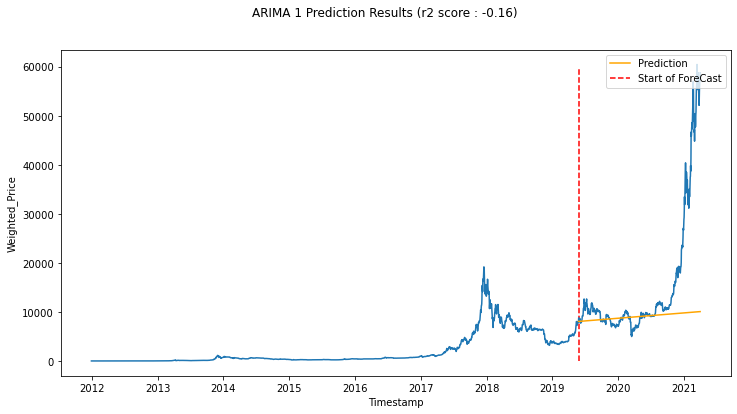

In [238]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=btc_daily, x=btc_daily.index, y='Weighted_Price', ax=ax)
ax.vlines(datetime(2019,5,26),0,60000, linestyle='--', color='r', label='Start of ForeCast')
ax.plot(predict_index, predicted_value, color='orange', label='Prediction')
plt.legend(loc='upper right')
plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Results (r2 score : {round(r2,2)})")

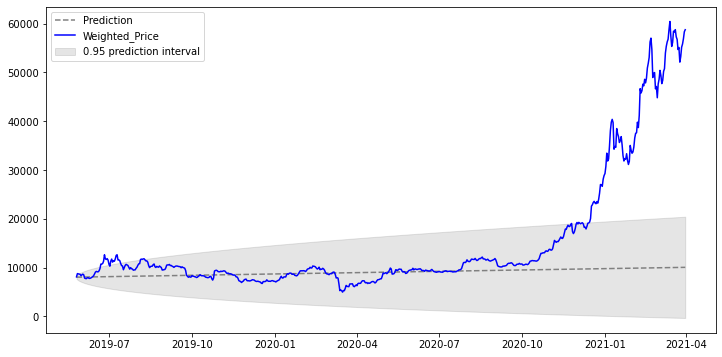

In [239]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, linestyle='--', label='Prediction',color='gray')
ax.plot(btc_daily[predict_index[0]:].index, btc_daily[predict_index[0]:], label='Weighted_Price', color='blue')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.show()

## Fitting modeling - SARIMA

In [240]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [241]:
# SARIMA
# parameter search
print("Examples of parameter combinataions for Seasonal ARIMA")
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train.values, order = (i), seasoanl_order = (j))
            model_fit = model.fit()
            print(f"SARIMA : {i}{j} >> AIC {round(model_fit.aic,2)}")
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
        except:
            pass

Examples of parameter combinataions for Seasonal ARIMA
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC 35434.0
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC 35434.0
SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC 35434.0
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC 35434.0
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC 35434.0
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC 35434.0
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC 35434.0
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC 35434.0
SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC 35434.0
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC 35343.91
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC 35343.91
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC 35343.91
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC 35343.91
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC 35343.91
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC 35343.91
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC 35343.91
SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC 35343.91
SARIMA : (0, 1, 1)(2, 1, 2, 12) >> AIC 35343.91
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC 35327.39
SARIMA : (0, 1, 2)(0, 1, 1, 12) >> AIC 353

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA : (2, 1, 1)(0, 1, 0, 12) >> AIC 35297.58
SARIMA : (2, 1, 1)(0, 1, 1, 12) >> AIC 35297.58
SARIMA : (2, 1, 1)(0, 1, 2, 12) >> AIC 35297.58
SARIMA : (2, 1, 1)(1, 1, 0, 12) >> AIC 35297.58
SARIMA : (2, 1, 1)(1, 1, 1, 12) >> AIC 35297.58
SARIMA : (2, 1, 1)(1, 1, 2, 12) >> AIC 35297.58
SARIMA : (2, 1, 1)(2, 1, 0, 12) >> AIC 35297.58
SARIMA : (2, 1, 1)(2, 1, 1, 12) >> AIC 35297.58
SARIMA : (2, 1, 1)(2, 1, 2, 12) >> AIC 35297.58
SARIMA : (2, 1, 2)(0, 1, 0, 12) >> AIC 35297.66
SARIMA : (2, 1, 2)(0, 1, 1, 12) >> AIC 35297.66
SARIMA : (2, 1, 2)(0, 1, 2, 12) >> AIC 35297.66
SARIMA : (2, 1, 2)(1, 1, 0, 12) >> AIC 35297.66
SARIMA : (2, 1, 2)(1, 1, 1, 12) >> AIC 35297.66
SARIMA : (2, 1, 2)(1, 1, 2, 12) >> AIC 35297.66
SARIMA : (2, 1, 2)(2, 1, 0, 12) >> AIC 35297.66
SARIMA : (2, 1, 2)(2, 1, 1, 12) >> AIC 35297.66
SARIMA : (2, 1, 2)(2, 1, 2, 12) >> AIC 35297.66


In [242]:
optimal = [params[np.argmin(aic)], min(aic)]
optimal

[((1, 1, 2), (0, 1, 0, 12)), 35297.2]

In [243]:
SARIMA_model_opt = SARIMAX(train.values, order=optimal[0][0], seasonal_order = optimal[0][1])
SARIMA_model_opt_fit = SARIMA_model_opt.fit()
SARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2700
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 12)   Log Likelihood              -18481.443
Date:                             Tue, 12 Oct 2021   AIC                          36970.886
Time:                                     22:51:30   BIC                          36994.470
Sample:                                          0   HQIC                         36979.417
                                            - 2700                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4722      0.048     -9.775      0.000      -0.567      -0.378
ma.L1          0.7280      0.048     15.179      0.000       0.634       0.822
ma.L2          0.1772      0.011     15.742      0.000       0.155       0.199
sigma2      5.535e+04    324.948    170.327      0.000    5.47e+04     5.6e+04
===================================================================================
Ljung-Box (Q):                      910.74   Jarque-Bera (JB):            238154.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             226.28   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [269]:
# use model to forecast
prediction = SARIMA_model_opt_fit.get_forecast(steps=len(test))
predicted_value = prediction.predicted_mean
predicted_lb = prediction.conf_int()[:,0]
predicted_ub = prediction.conf_int()[:,1]
predict_index = list(test.index)

r2 = r2_score(test, predicted_value)
r2

-0.164711004200206

get_prediction vs get_forecast??

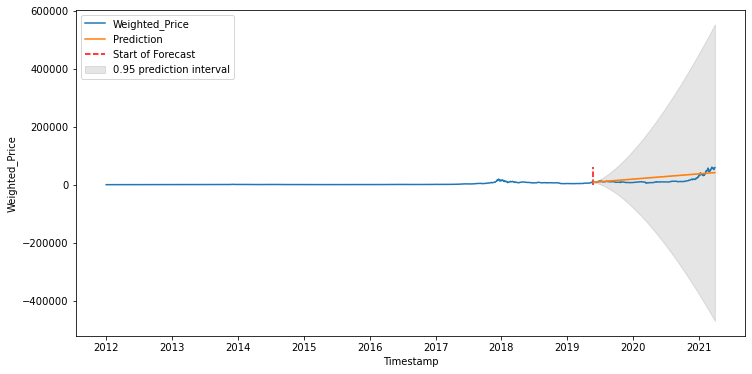

In [245]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=btc_daily, x=btc_daily.index, y='Weighted_Price', label='Weighted_Price')
ax.vlines(datetime(2019,5,26), 0, 60000, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.show()

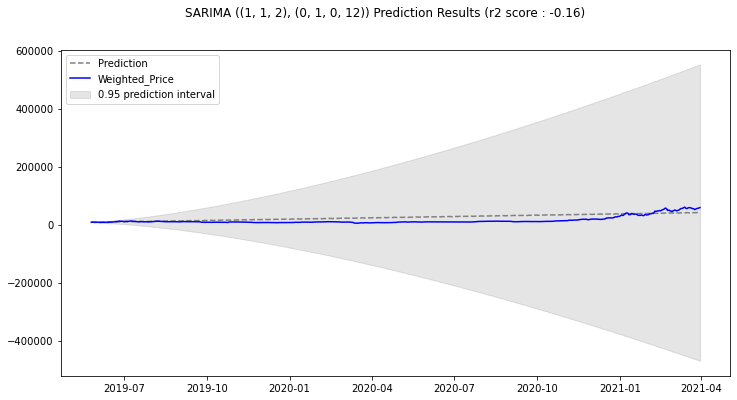

In [246]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, linestyle='--', label='Prediction', color='gray')
ax.plot(btc_daily[predict_index[0]:].index, btc_daily[predict_index[0]:], label='Weighted_Price', color='blue')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
plt.suptitle(f"SARIMA {optimal[0]} Prediction Results (r2 score : {round(r2,2)})")
plt.legend(loc='upper left')